# GP surrogate model

This notebook creates a surrogate model of EPANET's water quality solver using Gaussian Process (GP) regression.

In [1]:
import pandas as pd
import numpy as np
import joblib

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from bayesian_wq_calibration.epanet import build_model, sensor_model_id, epanet_simulator, set_reaction_parameters
from bayesian_wq_calibration.calibration import decision_variables_to_dict, generate_samples, setup_gp_model
from bayesian_wq_calibration.data import bulk_temp_adjust
from bayesian_wq_calibration.constants import TIMESERIES_DIR, RESULTS_DIR
from bayesian_wq_calibration.plotting import plot_gp_validation

model_dir = RESULTS_DIR / 'wq/gp_models'
model_dir.mkdir(parents=True, exist_ok=True)

### Load data

Load operational data for selected sensing period.

In [2]:
data_period = 18 # 20 calibration events (as at 30 October 2024)
wq_sensors_used = 'kiosk + hydrant' # 'kiosk only', 'kiosk + hydrant'
demand_resolution = 'wwmd' # 'dma', 'wwmd'
try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
except:
    print(f"Data period {data_period} does not exist.")

Surrogate model data period.

In [3]:
surrogate_days = 5

n_total = len(flow_df['datetime'].unique())
n_surrogate = surrogate_days * 24 * 4
surrogate_range = range(n_surrogate)
surrogate_datetime = flow_df['datetime'].unique()[list(surrogate_range)]
total_range = range(n_total)
total_datetime = flow_df['datetime'].unique()[list(total_range)]

Bulk decay.

In [4]:
bulk_coeff = -0.85 # day^-1 (from bottle tests)
field_temp = wq_df[wq_df['data_type'] == 'temperature']['mean'].mean()
bulk_coeff = bulk_temp_adjust(bulk_coeff, field_temp)

Wall decay grouping.

In [10]:
# see notebook `02-pipe-grouping-exploration.ipynb` for details on pipe groups
grouping = 'material-age-velocity'

# load ga results to get param_mean data
ga_results_df = pd.read_excel(RESULTS_DIR / 'wq/ga_calibration.xlsx', sheet_name=grouping)
ga_results_df = ga_results_df[(ga_results_df['data_period'] == data_period) & (ga_results_df['demand_resolution'] == demand_resolution) & (ga_results_df['wq_sensors_used'] == wq_sensors_used)]
ga_results = ga_results_df[[col for col in ga_results_df.columns if col.startswith('G')]].values[0]

grouping_data = {
    'single': {
        'param_group': ['G0'],
        'param_bounds': [(-0.5, 0.0)],
        'param_mean': ga_results
    },
    'material-only': {
        'param_group': ['G0', 'G1'],
        'param_bounds': [(-1.0, -0.01), (-0.5, -0.01), (-0.15, -0.01)],
        'param_mean': ga_results
    },
    'material-age-diameter': {
        'param_group': ['G0', 'G1', 'G2', 'G3', 'G4', 'G5'],
        'param_bounds': [(-1.0, -0.01), (-1.0, -0.01), (-0.5, -0.01), (-0.5, -0.01), (-0.2, -0.01)],
        'param_mean': ga_results
    },
    'material-age-velocity': {
        'param_group': ['G0', 'G1', 'G2', 'G3', 'G4', 'G5'],
        'param_bounds': [(-1.0, -0.01), (-1.0, -0.01), (-0.5, -0.01), (-0.5, -0.01), (-0.2, -0.01)],
        # 'param_mean': ga_results
        'param_mean': [-0.5, -0.5, -0.2, -0.2, -0.05]
    }
}

param_data = grouping_data[grouping]
param_group = param_data['param_group']
param_bounds = param_data['param_bounds']
param_mean = param_data['param_mean']

### Surrogate model

**EPANET simulator**

Build water model using `wntr`.

In [11]:
wn = build_model(flow_df[flow_df['datetime'].isin(surrogate_datetime)], pressure_df[pressure_df['datetime'].isin(surrogate_datetime)], cl_df[cl_df['datetime'].isin(surrogate_datetime)], sim_type='chlorine', demand_resolution=demand_resolution, bulk_coeff=bulk_coeff)

Get mean velocities (for 'material-velocity' grouping).

Define simualtor function.

In [12]:
def simulator(cl_df, params, wn, grouping):
    """Run EPANET simulation with given parameters."""
    wall_coeffs = decision_variables_to_dict(grouping, params)
    _wn = set_reaction_parameters(wn, grouping, wall_coeffs, bulk_coeff)
    
    sim_results = epanet_simulator(_wn, 'chlorine', cl_df)
    cl_sim = sim_results.chlorine
    
    sensor_data = sensor_model_id('wq')
    cl_sim = cl_sim[sensor_data['model_id'].unique()]
    name_mapping = sensor_data.set_index('model_id')['bwfl_id'].to_dict()
    cl_sim = cl_sim.rename(columns=name_mapping)

    cl_sim = cl_sim.T
    cl_sim.columns = [f't_{idx+1}' for idx in range(cl_sim.shape[1])]
    cl_sim = cl_sim.drop(index=['BW1', 'BW4'], errors='ignore')  # remove inlet sensors
    
    return cl_sim

In [13]:
cl_simulator = simulator(cl_df[cl_df['datetime'].isin(surrogate_datetime)], param_mean, wn, grouping)
sensor_names = cl_simulator.index.to_numpy()

**Design of experiments**

Call `generate_samples` function, which takes the following inputs:
- `sampling_method` (default = latin hypercube sampling)
- `dist_type` (default = truncated normal)
- `rel_uncertainty` (default = 50% of parameter mean)

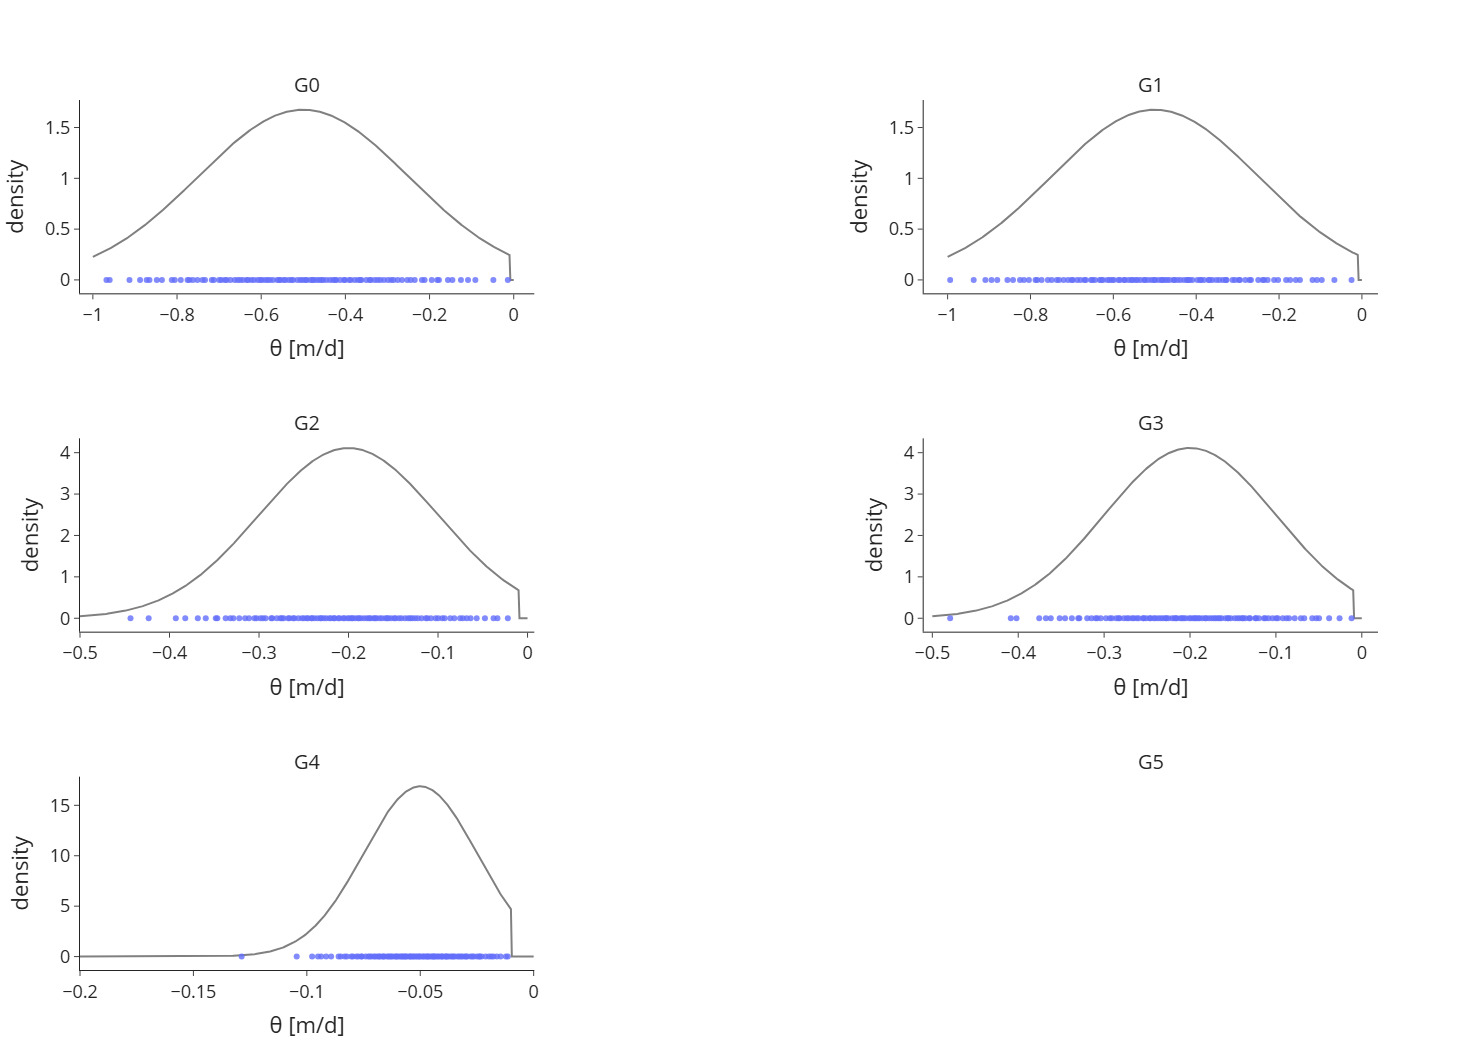

In [14]:
n_samples_idx = 3
n_samples = [10, 25, 50, 100, 200]

X = generate_samples(param_mean, param_bounds, param_group, n_samples[n_samples_idx], sampling_method='lhs', dist_type='truncated normal', rel_uncertainty=0.5, plot=True)

In [ ]:
n_samples_idx = 3
n_samples = [10, 25, 50, 100, 200]

X = generate_samples(param_mean, param_bounds, param_group, n_samples[n_samples_idx], sampling_method='lhs', dist_type='triangle', rel_uncertainty=0.5, plot=True)
Y = np.array([
    simulator(cl_df[cl_df['datetime'].isin(surrogate_datetime)], params, wn, grouping)
    for params in X
])

**Cross-validation of GP regression training**

Training procedure using five-fold cross-validation and `scikit-learn` modules. The following kernel's can be used:
- Radial basis function (RBF)
- Matern
- Rational quadratic

Note: a separate GP is trained for each of the **7** sensors.

In [ ]:
sensor = 'BW2' # 'BW2', 'BW3', 'BW5', 'BW6', 'BW7', 'BW9', 'BW12'
s = np.where(sensor_names == sensor)[0][0]
Y_s = Y[:, s, :].reshape(Y.shape[0], Y.shape[2])

In [ ]:
# split data for training and testing
n_0 = round(0.8*len(X))
X_train = X[:n_0]
Y_train = Y_s[:n_0]
X_test = X[n_0:]
Y_test = Y_s[n_0:]

Set model parameters.

In [ ]:
# scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
kernel_type = 'RBF'

Cross-validation.

In [ ]:
# k_folds = 5
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # cross-validation loop
# hyperparameter_performance = []
# for fold, (train_idx, validate_idx) in enumerate(kf.split(X_train_scaled)):
    
#     X_cv_train, X_cv_validate = X_train_scaled[train_idx], X_train_scaled[validate_idx]
#     Y_cv_train, Y_cv_validate = Y_train[train_idx], Y_train[validate_idx]
    
#     gp = setup_gp_model(X_train.shape[1], kernel_type=kernel_type)
#     gp.fit(X_cv_train, Y_cv_train)
    
#     Y_cv_pred = gp.predict(X_cv_validate)
    
#     # performance metrics
#     rmse = np.sqrt(mean_squared_error(Y_cv_validate, Y_cv_pred))
#     mae = mean_absolute_error(Y_cv_validate, Y_cv_pred)
#     maxae = np.max(np.abs(Y_cv_validate - Y_cv_pred))
#     hyperparameter_performance.append({
#         "fold": fold + 1,
#         "rmse": rmse,
#         "mae": mae,
#         "maxae": maxae,
#         "length_scale": gp.kernel_.get_params()['k2__length_scale'],
#         "variance": gp.kernel_.get_params()['k1__constant_value']
#     })
    
#     print(f"Fold {fold + 1} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MaxAE: {maxae:.4f}")

**Train GP model with entire dataset (or load an existing model).**

In [ ]:
filename = f'gp_{data_period}_{sensor}_{demand_resolution}_{surrogate_days}-day_sim.joblib'
model_path = model_dir / filename
train_model = True

if not train_model:
    try:
        print(f"Attempting to load saved model: {filename}")
        model_data = joblib.load(model_path)
        gp = model_data['gp_model']
        scaler = model_data['scaler']
        print(f"Successfully loaded saved model: {filename}")
        
    except FileNotFoundError:
        print(f"No saved model found at {model_path}")
        print("Set `train_model=True` and re-run code block.")
else:
        
    # train model using entire dataset
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    gp = setup_gp_model(X_train.shape[1], kernel_type='RBF')
    gp.fit(X_train_scaled, Y_train)
    
    # save newly trained model
    model_save = {
        'gp_model': gp,
        'scaler': scaler,
        'kernel_params': gp.kernel_.get_params(),
        'sensor_name': sensor
    }
    
    model_dir.mkdir(parents=True, exist_ok=True)
    joblib.dump(model_save, model_path)
    print(f"New model trained and saved to: {model_path}")

# print GP model parameters
print("GP model parameters:")
print(gp.kernel_.get_params())

**GP model testing**

In [ ]:
Y_pred, Y_std = gp.predict(X_test_scaled, return_std=True)

Test results plotting.

In [ ]:
# performance metrics
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae = mean_absolute_error(Y_test, Y_pred)
maxae = np.max(np.abs(Y_test - Y_pred))
r2 = 1 - np.sum((Y_test - Y_pred) ** 2) / np.sum((Y_test - Y_test.mean()) ** 2)

print(f"\nPerformance metrics (test dataset).")
print(f"Root mean squared error: {rmse:.4f}")
print(f"Mean absolute error: {mae:.4f}")
print(f"Maximum absolute error: {maxae}")
print(f"R² Score: {r2:.4f}")

# visualization

# parity plot
fig = go.Figure(data=go.Scatter(
    x=Y_test.flatten(),
    y=Y_pred.flatten(),
    mode='markers',
    marker=dict(size=6, opacity=0.6),
))
fig.update_layout(
    title="EPANET vs GP",
    xaxis_title="EPANET simulator [mg/L]",
    yaxis_title="GP surrogate [mg/L]",
    template="simple_white",
    width=550,
    height=450
)
fig.show()

# error distribution
errors = (Y_test - Y_pred).flatten()
fig = go.Figure(data=[go.Histogram(x=errors, nbinsx=40)])
fig.update_layout(
    title="Error distribution",
    xaxis_title="Error [mg/L]",
    yaxis_title=f"Frequency (n={len(errors)})",
    template="simple_white",
    width=550,
    height=450
)
fig.show()

# cdf plot of absolute errors
absolute_errors = np.abs(Y_test - Y_pred).flatten()
sorted_errors = np.sort(absolute_errors)
cdf_values = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=sorted_errors,
    y=cdf_values,
    mode='lines',
    line=dict(width=2)
))

fig.update_layout(
    title='Cumulative distribution of absolute errors',
    xaxis_title='Absolute error [mg/L]',
    yaxis_title='Cumulative probability',
    template='simple_white',
    width=550,
    height=450,
    showlegend=False
)

In [ ]:
plot_gp_validation(Y_test, Y_pred, Y_std, surrogate_datetime[surrogate_range], sensor)